In [1]:
import tensorflow_probability as tfp
import numpy as np
import tensorflow as tf

import time
from tqdm import tqdm
import pickle

from math import *

import matplotlib.dates as mdates
import matplotlib.ticker as ticker

myFmt = mdates.DateFormatter('%Hh')

import pandas as pd
np.set_printoptions(suppress=True,precision=6)
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid')

import sys

from tensorflow_probability import distributions as tfd
from geopy.distance import geodesic

%matplotlib inline

from move_ns import moveNS

## Load data and display individual time series lengths

In [2]:
# set up lower level GP locations covering 24 hours
Z = np.linspace(0,24,num=25,endpoint=False).astype(np.float64)[:,None]
#np.random.shuffle(Z)


In [36]:
def setup_data(skip_i=1,skip=3):
    
    df = pd.read_csv('data/ovejas.csv')

    df = df[df.id!=34]
    
    



    df['ID'] = df['id'].astype('category').cat.rename_categories(range(0, df['id'].nunique())).astype('int')
    df = df[df['ID']%skip_i==0]
    df = df[df['ID'].isin(np.arange(0,20,2))]
    
    ID = df['ID'].values 
    
    
    
    Xgps = df[['lat','lon']].values
    minX = np.min(Xgps[:,0])
    minY = np.min(Xgps[:,1])




    secs =(pd.to_datetime(df['time'])- pd.datetime(2018,1,1)).dt.seconds.astype(float).values
    days = (pd.to_datetime(df['time'])- pd.datetime(2018,1,1)).dt.days.astype(float).values
    T = (days*24*60+secs/60)/(60*24) #days
    T = T-np.min(T)

    rescale = 24  # use hours to improve numerical stability
    T = T * rescale


    




    # use geodesic to get the straight line distance between two points
    Xmetres = np.array([geodesic((xloc,minY), (minX,minY)).meters for xloc in Xgps[:,0]])
    Ymetres = np.array([geodesic((minX,yloc), (minX,minY)).meters for yloc in Xgps[:,1]])

    


    X = np.array([Xmetres, Ymetres]).T
    
    T=T[::skip,None]
    X=X[::skip]
    ID=ID[::skip]

    return X, T, ID


In [37]:
np.arange(0,20,2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

In [38]:
X,T,ID = setup_data(skip_i=1,skip=2)
X[:,0] = X[:,0]-X[:,0].mean()
X[:,1] = X[:,1]-X[:,1].mean()
X[:,0] = X[:,0]/1000
X[:,1] = X[:,1]/1000

print(X.shape)

/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


(81896, 2)


In [39]:
def sp_shift(x):
    # softplus transform with shift 
    return tf.nn.softplus(x)+1e-4

## Set-up the non-stationary GP

In [40]:


def periodic_kernel(x1,x2):
    # periodic kernel with parameter set to encode
    # daily activity pattern (period=rescale).
    return tfp.math.psd_kernels.ExpSinSquared(x1,x2,np.float64(24.0))

# transform for parameter to ensure positive
transforms=[sp_shift,sp_shift] 
#transforms=[sp_shift] 

# diffuse priors on parameters
lpriors = [tfd.Normal(loc = np.float64(0),scale=np.float64(1)),
           tfd.Normal(loc = np.float64(0),scale=np.float64(10.))]
           
apriors = [tfd.Normal(loc = np.float64(0.),scale=np.float64(1)),
           tfd.Normal(loc = np.float64(0),scale=np.float64(10.))]


lparams_init = [0.0,0.0]
aparams_init = [0.0,0.0]


# create the model #2880
mover = moveNS(T,X,Z, ID, BATCH_SIZE=1000, MIN_REMAIN=500,velocity=True, std_obs_noise=100, mean_obs_noise=10,
                        akernel=periodic_kernel, 
                        aparams_init=aparams_init, 
                        apriors=apriors, 
                        atransforms=transforms,
                        lkernel=periodic_kernel, 
                        lparams_init=lparams_init, 
                        lpriors=lpriors, 
                        ltransforms=transforms)


#-mover.log_posterior(*mover.kernel_params)


In [ ]:

learning_rate = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=50,
    decay_rate=0.99,
    staircase=True)


optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_2=0.99)
train_steps = 2000
pbar = tqdm(range(train_steps))
loss_history = np.zeros((train_steps))
for i in pbar:
    with tf.GradientTape() as t:
        loss = -mover.log_posterior(*mover.kernel_params)
    loss_history[i] = loss.numpy()
    pbar.set_description("Loss %f" % (loss_history[i]))

    gradients = t.gradient(loss, mover.kernel_params)
    optimizer.apply_gradients(zip(gradients, mover.kernel_params))
#n=3.5


Loss 57567.712532:  83%|████████▎ | 1662/2000 [23:29<04:46,  1.18it/s]

In [ ]:
plt.plot(loss_history[800:])

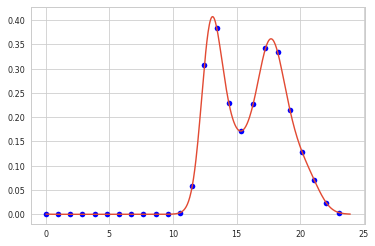

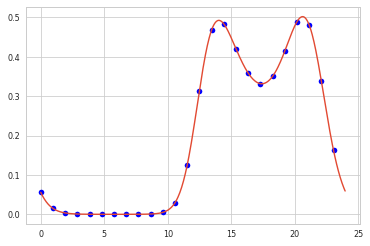

In [49]:
lengths = mover.get_lengthscale()
plt.plot(Z,lengths,'o',c='b')
Zin = np.linspace(0,24,num=500,endpoint=False).astype(np.float64)[:,None]

lengths = mover.get_lengthscale(X=Zin)
plt.plot(Zin,lengths)
plt.show()

amps = mover.get_amplitude()
plt.plot(Z,amps,'o',c='b')
Zin = np.linspace(0,24,num=500,endpoint=False).astype(np.float64)[:,None]
amps = mover.get_amplitude(X=Zin)
plt.plot(Zin,amps)
plt.show()


In [56]:
opt_params = [i.numpy() for i in  mover.kernel_params]

with open('opt_params.npy', 'wb') as fp:
    pickle.dump(opt_params, fp)



In [57]:
with open ('opt_params.npy', 'rb') as fp:
    opt_params = pickle.load(fp)
    opt_obs_noise = opt_params[0]
    opt_ls_v = opt_params[1]
    opt_ls_amp = sp_shift(opt_params[2]).numpy()
    opt_ls_ls = sp_shift(opt_params[3]).numpy()
    opt_amp_v = opt_params[4]
    opt_amp_amp = sp_shift(opt_params[5]).numpy()
    opt_amp_ls = sp_shift(opt_params[6]).numpy()
    


In [58]:

def ls_periodic_kernel():
    # periodic kernel with single variable parameter. Other parameters are set 
    # to encode daily activity pattern (period=rescale).
    # 15 minute correlation time
    return tfp.math.psd_kernels.ExpSinSquared(np.float64(opt_ls_amp),np.float64(opt_ls_ls),np.float64(24.0))

def amp_periodic_kernel():
    # periodic kernel with single variable parameter. Other parameters are set 
    # to encode daily activity pattern (period=rescale).
    # 15 minute correlation time
    return tfp.math.psd_kernels.ExpSinSquared(np.float64(opt_amp_amp),np.float64(opt_amp_ls),np.float64(24.0))


# transform for parameter to ensure positive
transforms=[] 

# prior distribution on parameters - changed to 20 
lpriors =[]#tfd.Normal(loc = np.float64(opt_ls_mean),scale=np.float64(10))]
apriors =[]#tfd.Normal(loc = np.float64(opt_amp_mean),scale=np.float64(10))]

# random initial values of mean and kernel amplitude
lparams_init =[]
aparams_init = []

# create the model 


mover_hmc = moveNS(T,X,Z, ID, BATCH_SIZE=1000, MIN_REMAIN= 500, velocity=True, std_obs_noise=0, mean_obs_noise=opt_obs_noise,
                        akernel=amp_periodic_kernel, 
                        aparams_init=aparams_init, 
                        apriors=apriors, 
                        atransforms=transforms,
                        lkernel=ls_periodic_kernel, 
                        lparams_init=lparams_init, 
                        lpriors=lpriors, 
                        ltransforms=transforms)

# mover_hmc.kernel_params[0].assign(opt_ls_v)
# mover_hmc.kernel_params[1].assign(opt_amp_v)

In [13]:
# move to its own class

In [ ]:



def log_normal_pdf_unn(x, mean, variance, inv_variance=None):
    """
    log of unnormalized pdf of a normal distribution.

    Parameters
    ----------
    x
        Where to evaluate the Normal.
    mean, variance:
        parameters of the gaussian.
    inv_variance
        Inverse of the variance (to avoid computing it again and again in certain cases).

    Returns
    -------
    float: the result.
    """
    if inv_variance is None:
        inv_variance = np.linalg.inv(variance)
    return -1 / 2 * (x - mean) @ (inv_variance @ (x - mean))





def projection_operators(epsilon_1, A_1):
    """
    Return the projection functions defined in the article.

    Parameters
    ----------
    epsilon_1, A_1:
        The two scaling operators.

    Returns
    -------
    proj_sigma: Projection on segment epsilon_1, A_1
    proj_gamma: Projection on cone of definite matrix of norm < 1_1
    proj_mu: Projection on centered ball of radius A_1
    """

    def proj_sigma(x: float) -> float:
        if x < epsilon_1:
            return epsilon_1
        elif x > A_1:
            return A_1
        else:
            return x

    def proj_gamma(x: np.ndarray) -> np.ndarray:
        assert x.ndim == 2
        norm = np.linalg.norm(x, ord='fro')  # Frobenius norm
        if norm > A_1:
            print(f"Projection on Gamma! norm={norm:.1e}")
            return A_1 / norm * x
        else:
            return x

    def proj_mu(x: np.ndarray) -> np.ndarray:
        assert x.ndim == 1
        norm = np.linalg.norm(x, ord=2)
        if norm > A_1:
            print(f"Projection on mu! norm={norm:.1e}")
            return A_1 / norm * x
        else:
            return x

    return proj_sigma, proj_gamma, proj_mu



    


class AdaptiveMALA():
    def __init__(self, state, log_pdf,
                 drift,
                 epsilon_1=1e-5,
                 epsilon_2=1e-6,
                 A_1=1e7,
                 tau_bar=0.574,
                 mu_0=None,
                 gamma_0=None,
                 sigma_0=1,
                 robbins_monroe=10,
                 threshold_start_estimate=100,
                 threshold_use_estimate=200,
                 ):
        """
        Adaptative MALA sampler, described in [1].

        Parameters
        ----------
        state: initial state to start in.
        pi: Callable. Unnormalized pdf of the distribution we want to approximate.
        log_pi: log of the distribution we want to approximate
        drift: Callable.
        epsilon_1, epsilon_2, A_1: parameters of the HM algorithm. Must verify: 0 < epsilon_1 < A_1, 0 < epsilon_2.
        tau_bar: target optimal acceptation rate.
        mu_0, gamma_0, sigma_0: initial values for the parameters.
        robbins_monroe: constant c_0 for the robbins monroe coefficients: g_n = c_0/n
        threshold_use_estimate: int corresponding to the number of steps after which we start updating the covariance
        matrix

        References
        ----------
        [1] An adaptive version for the Metropolis adjusted Langevin algorithm with a truncated drift, Yves F. Atchadé

        """
        #super(AdaptiveMALA, self).__init__(state, pi, log_pi, drift, tau_bar, gamma_0, sigma_0, epsilon_2,
                                           #robbins_monroe)
        #super(AdaptiveMALA, self).__init__(state, pi, log_pi)
        self.dims = state.shape[0]
        self.state = state
        self.log_pdf = log_pdf
        self.acceptance_rate = 0
        self.steps = 0
        self.history = {'state': [state], 'acceptance rate': []}

        if mu_0 is None:
            mu_0 = state
        if gamma_0 is None:
            gamma_0 = np.eye(self.dims)

        self.drift = drift
        self.tau_bar = tau_bar
        self.gamma = gamma_0
        self.sigma = sigma_0
        self.A_1 = A_1
        self.epsilon_1 = epsilon_1
        self.epsilon_2 = epsilon_2
        self.c_0 = robbins_monroe
        self._gamma_estimate = self.gamma.copy()
        self.params_history = {'gamma': [gamma_0.copy()],'sigma': [sigma_0]}


        self.epsilon_1 = epsilon_1

        self.mu = mu_0
        self.proj_sigma, self.proj_gamma, self.proj_mu = projection_operators(epsilon_1, A_1)
        self.threshold_use_estimate = threshold_use_estimate
        self.threshold_start_estimate = threshold_start_estimate
        self.params_history['mu'] = [mu_0.copy()]

    
    def run_sampler(self,n_samples, n_burn, thin=1):
        """
        Draw samples from the chain.

        Returns
        -------
        The new state.
        """
        self.steps = 0
        
        samples = np.zeros((n_samples,self.dims))
        
        # total iterations for number of samples
        iters = (n_samples * thin) + n_burn
        
        
        pbar = tqdm(range(iters))
        self.state_log_pdf = self.log_pdf(self.state)
        self.state_drift = self.drift(self.state)
        for i in pbar:
            self.steps += 1
            self.proposal = self.proposal_sampler()
            self.proposal_log_pdf = self.log_pdf(self.proposal)
            self.proposal_drift = self.drift(self.proposal)

            alpha = self.acceptance_ratio()
            
            u = np.random.uniform(0, 1)
            if u <= alpha:
                self.state = self.proposal
                self.acceptance_rate = ((self.steps - 1) * self.acceptance_rate + 1) / self.steps
                self.state_log_pdf = self.proposal_log_pdf.copy()
                self.state_drift = self.proposal_drift.copy()

            else:
                self.acceptance_rate = ((self.steps - 1) * self.acceptance_rate) / self.steps
            pbar.set_description("AR %f SS %f" % (self.acceptance_rate,self.sigma))

            self.history['state'].append(self.state.copy())
            self.history['acceptance rate'].append(self.acceptance_rate)

            #print(self.state[0])
            if i >= n_burn and i % thin == 0:
                samples[(i - n_burn) // thin] = self.state

            if i < n_burn:
                self.update_params(alpha=alpha)
            assert np.isfinite(self.state).all()
            assert np.isfinite(self.gamma).all()

        return samples
    

    
    def acceptance_ratio(self):
        """
        Compute the alpha parameter for the proposal, given the state we are in (self.state).

        Parameters
        ----------
        proposal
            The proposal value, given by e.g. proposal_sampler()
        log
            Computing acceptance_ratio using log trick

        Returns
        -------
        A float between 0 and 1.
        """
        
        arg_exp = self.proposal_log_pdf - self.state_log_pdf \
                  + self.fwd_log_proposal_value() - self.bkwd_log_proposal_value()
        #arg_exp = arg_exp.numpy()
        if np.isfinite(arg_exp):
            alpha = np.exp(min(0, arg_exp))
        else:
            alpha=0
        
        return alpha
    
    def proposal_sampler(self) -> np.ndarray:
        big_lambda = self.gamma + self.epsilon_2 * np.eye(self.dims)
        mean = self.state + self.sigma ** 2 / 2 * big_lambda @ self.state_drift
        variance = self.sigma ** 2 * big_lambda
        sample = np.random.multivariate_normal(mean=mean, cov=variance)
        return sample

    def fwd_log_proposal_value(self):
        big_lambda = self.gamma + self.epsilon_2 * np.eye(self.dims)
        mean = self.proposal + self.sigma ** 2 / 2 * big_lambda @ self.proposal_drift
        variance = self.sigma ** 2 * big_lambda
        value = log_normal_pdf_unn(self.state, mean, variance)
        return value

    def bkwd_log_proposal_value(self):
        big_lambda = self.gamma + self.epsilon_2 * np.eye(self.dims)
        mean = self.state + self.sigma ** 2 / 2 * big_lambda @ self.state_drift
        variance = self.sigma ** 2 * big_lambda
        value = log_normal_pdf_unn(self.proposal, mean, variance)
        return value
    
    def log_proposal_value(self, x, y):
        big_lambda = self.gamma + self.epsilon_2 * np.eye(self.dims)
        mean = x + self.sigma ** 2 / 2 * big_lambda @ self.drift(x)
        variance = self.sigma ** 2 * big_lambda
        value = log_normal_pdf_unn(y, mean, variance)
        return value


    def update_params(self, alpha):
        
        """


        Parameters
        ----------
        model: instance of AdaptiveMALA or AdaptiveSymmetricRW
        alpha: the acceptance ratio

        Updates the parameters of the instance.
        """
        coeff = self.c_0 / self.steps

        


        # _gamma_estimate holds the estimation of the covariance matrix.
        # It is different from gamma: indeed, we want to estimate the covariance matrix without using it at first.
        if self.steps > self.threshold_start_estimate:
            coeff_gamma = self.c_0 / (self.steps - self.threshold_start_estimate)
            covariance = (self.state - self.mu)[:, np.newaxis] @ (self.state - self.mu)[np.newaxis, :]
            #covariance = np.diag((self.state - self.mu)**2)

            self._gamma_estimate = self.proj_gamma(self._gamma_estimate + coeff_gamma * (covariance - self._gamma_estimate))
        if self.steps > self.threshold_use_estimate:
            self.gamma = self._gamma_estimate
        
        
        self.mu = self.proj_mu(self.mu + coeff * (self.state - self.mu))

        self.params_history['gamma'].append(self.gamma.copy())
        self.params_history['mu'].append(self.mu.copy())

        
        self.sigma = self.proj_sigma(self.sigma + coeff * (alpha - self.tau_bar))
        self.params_history['sigma'].append(self.sigma)

In [51]:


def to_numpy(params):
    return np.hstack([mk.numpy() for mk in params])

def set_state(array):
    
    dims=[]
    for a in mover_hmc.kernel_params:
        if tf.rank(a)==0:
            dims.append(1)
        else:
            dims.append(a.shape[0])
    dims=np.cumsum(dims)[:-1]
    for a, b in zip(np.split(array,dims), mover_hmc.kernel_params):
        b.assign(a.squeeze())
    return
    
    
def drift(x):
    delta = 1000
    set_state(x)
    
    with tf.GradientTape() as t:
        logpdf = mover_hmc.log_posterior(*mover_hmc.kernel_params)
    
    gradients = t.gradient(logpdf, mover_hmc.kernel_params)
    grad_log_pdf_x = to_numpy(gradients)
    
    
    return delta * grad_log_pdf_x / max(delta, np.linalg.norm(grad_log_pdf_x))

def log_pdf(x):
    set_state(x)
    return mover_hmc.log_posterior(*mover_hmc.kernel_params).numpy()

In [59]:
#initial_state= to_numpy(mover.kernel_params)
opt_params = [i.numpy() for i in  mover.kernel_params]
opt_ls_v = opt_params[1]
opt_amp_v = opt_params[4]
    
initial_state=np.hstack([opt_ls_v,opt_amp_v])

adapt_t_mala_model = AdaptiveMALA(drift=drift,
                                    log_pdf=log_pdf, 
                                    state= initial_state,
                                    sigma_0=1,
                                    threshold_start_estimate=500,
                                    threshold_use_estimate=1000)

In [ ]:

amala_samples = adapt_t_mala_model.run_sampler(500,20000,10)

AR 0.620078 SS 1.156553:   7%|▋         | 1803/25000 [46:26<9:58:11,  1.55s/it] 

In [23]:
pamala_samples.shape

(500, 50)

In [24]:
dims=[]
for a in mover_hmc.kernel_params:
    if tf.rank(a)==0:
        dims.append(1)
    else:
        dims.append(a.shape[0])
dims=np.cumsum(dims)[:-1]

In [25]:
samples2 = [tf.convert_to_tensor(a,dtype=tf.float64) for a in np.split(amala_samples,dims,axis=-1)]

In [26]:
samples2

[<tf.Tensor: shape=(500, 25), dtype=float64, numpy=
 array([[-2.347574, -2.442622, -0.872517, ..., -3.004577,  0.927291,
         -1.126554],
        [-3.135629, -4.270181, -1.809438, ..., -1.149626, -0.65627 ,
         -0.188711],
        [-2.477146, -2.71075 , -1.755625, ...,  1.42354 , -0.364357,
          1.20234 ],
        ...,
        [-2.958608, -3.854822, -1.2794  , ...,  0.380425, -1.205614,
         -0.166131],
        [-2.594342, -2.787272, -0.249474, ...,  0.705089, -1.330893,
         -1.335303],
        [-2.665655, -3.929114, -1.681243, ..., -0.871166,  1.21368 ,
          1.107532]])>,
 <tf.Tensor: shape=(500, 25), dtype=float64, numpy=
 array([[-1.220309, -3.727727, -3.896538, ..., -0.182388, -1.474863,
          0.438565],
        [-1.203126, -3.691001, -3.818124, ..., -0.669438, -1.329574,
          1.210008],
        [-1.233185, -3.876952, -4.197623, ..., -0.932258,  0.888002,
         -1.633471],
        ...,
        [-1.216494, -3.794292, -4.367301, ..., -2.581233,

In [ ]:
set_state(init_cond)

In [ ]:
init_cond = to_numpy(mover.kernel_params)

In [ ]:
mover.kernel_params


In [ ]:
lengths = mover.get_lengthscale()
plt.plot(Z,lengths,'o',c='b')
Zin = np.linspace(0,24,num=500,endpoint=False).astype(np.float64)[:,None]

lengths = mover.get_lengthscale(X=Zin)
plt.plot(Zin,lengths)
plt.show()

amps = mover.get_amplitude()
plt.plot(Z,amps,'o',c='b')
Zin = np.linspace(0,24,num=500,endpoint=False).astype(np.float64)[:,None]
amps = mover.get_amplitude(X=Zin)
plt.plot(Zin,amps)
plt.show()


In [ ]:
opt_params = [i.numpy() for i in  mover.kernel_params]

with open('opt_params.npy', 'wb') as fp:
    pickle.dump(opt_params, fp)



In [ ]:
with open ('opt_params.npy', 'rb') as fp:
    opt_params = pickle.load(fp)
    opt_obs_noise = opt_params[0]
    opt_ls_v = opt_params[1]
    opt_ls_amp = sp_shift(opt_params[2]).numpy()
    opt_ls_ls = sp_shift(opt_params[3]).numpy()
    opt_amp_v = opt_params[4]
    opt_amp_amp = sp_shift(opt_params[5]).numpy()
    opt_amp_ls = sp_shift(opt_params[6]).numpy()
    


In [ ]:
X,T,ID = setup_data(skip_i=1,skip=2)
X[:,0] = X[:,0]-X[:,0].mean()
X[:,1] = X[:,1]-X[:,1].mean()
X[:,0] = X[:,0]/1000
X[:,1] = X[:,1]/1000

print(X.shape)

In [ ]:

def ls_periodic_kernel():
    # periodic kernel with single variable parameter. Other parameters are set 
    # to encode daily activity pattern (period=rescale).
    # 15 minute correlation time
    return tfp.math.psd_kernels.ExpSinSquared(np.float64(opt_ls_amp),np.float64(opt_ls_ls),np.float64(24.0))

def amp_periodic_kernel():
    # periodic kernel with single variable parameter. Other parameters are set 
    # to encode daily activity pattern (period=rescale).
    # 15 minute correlation time
    return tfp.math.psd_kernels.ExpSinSquared(np.float64(opt_amp_amp),np.float64(opt_amp_ls),np.float64(24.0))


# transform for parameter to ensure positive
transforms=[] 

# prior distribution on parameters - changed to 20 
lpriors =[]#tfd.Normal(loc = np.float64(opt_ls_mean),scale=np.float64(10))]
apriors =[]#tfd.Normal(loc = np.float64(opt_amp_mean),scale=np.float64(10))]

# random initial values of mean and kernel amplitude
lparams_init =[]
aparams_init = []

# create the model 


mover_hmc = moveNS(T,X,Z, ID, BATCH_SIZE=1000, MIN_REMAIN= 500, velocity=True, std_obs_noise=0, mean_obs_noise=opt_obs_noise,
                        akernel=amp_periodic_kernel, 
                        aparams_init=aparams_init, 
                        apriors=apriors, 
                        atransforms=transforms,
                        lkernel=ls_periodic_kernel, 
                        lparams_init=lparams_init, 
                        lpriors=lpriors, 
                        ltransforms=transforms)

mover_hmc.kernel_params[0].assign(opt_ls_v)
mover_hmc.kernel_params[1].assign(opt_amp_v)

In [ ]:

learning_rate = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=50,
    decay_rate=0.99,
    staircase=True)


optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_2=0.99)
train_steps = 100
pbar = tqdm(range(train_steps))
loss_history = np.zeros((train_steps))
for i in pbar:
    with tf.GradientTape() as t:
        loss = -mover_hmc.log_posterior(*mover_hmc.kernel_params)
    loss_history[i] = loss.numpy()
    pbar.set_description("Loss %f" % (loss_history[i]))
    #pbar.set_description("Loss %f %f" % (loss_history[i],gradients[1].numpy()[0]))

    gradients = t.gradient(loss, mover_hmc.kernel_params)
    optimizer.apply_gradients(zip(gradients, mover_hmc.kernel_params))
#n=3.5


In [ ]:
lengths = mover_hmc.get_lengthscale()
plt.plot(Z,lengths,'o',c='b')
Zin = np.linspace(0,24,num=500,endpoint=False).astype(np.float64)[:,None]

lengths = mover_hmc.get_lengthscale(X=Zin)
plt.plot(Zin,lengths)
plt.show()

amps = mover_hmc.get_amplitude()
plt.plot(Z,amps,'o',c='b')
Zin = np.linspace(0,24,num=500,endpoint=False).astype(np.float64)[:,None]
amps = mover_hmc.get_amplitude(X=Zin)
plt.plot(Zin,amps)
plt.show()


In [ ]:



def log_normal_pdf_unn(x, mean, variance, inv_variance=None):
    """
    log of unnormalized pdf of a normal distribution.

    Parameters
    ----------
    x
        Where to evaluate the Normal.
    mean, variance:
        parameters of the gaussian.
    inv_variance
        Inverse of the variance (to avoid computing it again and again in certain cases).

    Returns
    -------
    float: the result.
    """
    if inv_variance is None:
        inv_variance = np.linalg.inv(variance)
    return -1 / 2 * (x - mean) @ (inv_variance @ (x - mean))





def projection_operators(epsilon_1, A_1):
    """
    Return the projection functions defined in the article.

    Parameters
    ----------
    epsilon_1, A_1:
        The two scaling operators.

    Returns
    -------
    proj_sigma: Projection on segment epsilon_1, A_1
    proj_gamma: Projection on cone of definite matrix of norm < 1_1
    proj_mu: Projection on centered ball of radius A_1
    """

    def proj_sigma(x: float) -> float:
        if x < epsilon_1:
            return epsilon_1
        elif x > A_1:
            return A_1
        else:
            return x

    def proj_gamma(x: np.ndarray) -> np.ndarray:
        assert x.ndim == 2
        norm = np.linalg.norm(x, ord='fro')  # Frobenius norm
        if norm > A_1:
            print(f"Projection on Gamma! norm={norm:.1e}")
            return A_1 / norm * x
        else:
            return x

    def proj_mu(x: np.ndarray) -> np.ndarray:
        assert x.ndim == 1
        norm = np.linalg.norm(x, ord=2)
        if norm > A_1:
            print(f"Projection on mu! norm={norm:.1e}")
            return A_1 / norm * x
        else:
            return x

    return proj_sigma, proj_gamma, proj_mu



    


class AdaptiveMALA():
    def __init__(self, state, log_pdf,
                 drift,
                 epsilon_1=1e-5,
                 epsilon_2=1e-6,
                 A_1=1e7,
                 tau_bar=0.574,
                 mu_0=None,
                 gamma_0=None,
                 sigma_0=1,
                 robbins_monroe=10,
                 threshold_start_estimate=100,
                 threshold_use_estimate=200,
                 ):
        """
        Adaptative MALA sampler, described in [1].

        Parameters
        ----------
        state: initial state to start in.
        pi: Callable. Unnormalized pdf of the distribution we want to approximate.
        log_pi: log of the distribution we want to approximate
        drift: Callable.
        epsilon_1, epsilon_2, A_1: parameters of the HM algorithm. Must verify: 0 < epsilon_1 < A_1, 0 < epsilon_2.
        tau_bar: target optimal acceptation rate.
        mu_0, gamma_0, sigma_0: initial values for the parameters.
        robbins_monroe: constant c_0 for the robbins monroe coefficients: g_n = c_0/n
        threshold_use_estimate: int corresponding to the number of steps after which we start updating the covariance
        matrix

        References
        ----------
        [1] An adaptive version for the Metropolis adjusted Langevin algorithm with a truncated drift, Yves F. Atchadé

        """
        #super(AdaptiveMALA, self).__init__(state, pi, log_pi, drift, tau_bar, gamma_0, sigma_0, epsilon_2,
                                           #robbins_monroe)
        #super(AdaptiveMALA, self).__init__(state, pi, log_pi)
        self.dims = state.shape[0]
        self.state = state
        self.log_pdf = log_pdf
        self.acceptance_rate = 0
        self.steps = 0
        self.history = {'state': [state], 'acceptance rate': []}

        if mu_0 is None:
            mu_0 = state
        if gamma_0 is None:
            gamma_0 = np.eye(self.dims)

        self.drift = drift
        self.tau_bar = tau_bar
        self.gamma = gamma_0
        self.sigma = sigma_0
        self.A_1 = A_1
        self.epsilon_1 = epsilon_1
        self.epsilon_2 = epsilon_2
        self.c_0 = robbins_monroe
        self._gamma_estimate = self.gamma.copy()
        self.params_history = {'gamma': [gamma_0.copy()],'sigma': [sigma_0]}


        self.epsilon_1 = epsilon_1

        self.mu = mu_0
        self.proj_sigma, self.proj_gamma, self.proj_mu = projection_operators(epsilon_1, A_1)
        self.threshold_use_estimate = threshold_use_estimate
        self.threshold_start_estimate = threshold_start_estimate
        self.params_history['mu'] = [mu_0.copy()]

    
    def run_sampler(self,n_samples, n_burn, thin=1):
        """
        Draw samples from the chain.

        Returns
        -------
        The new state.
        """
        self.steps = 0
        
        samples = np.zeros((n_samples,self.dims))
        
        # total iterations for number of samples
        iters = (n_samples * thin) + n_burn
        
        
        pbar = tqdm(range(iters))
        self.state_log_pdf = self.log_pdf(self.state)
        self.state_drift = self.drift(self.state)
        for i in pbar:
            self.steps += 1
            self.proposal = self.proposal_sampler()
            self.proposal_log_pdf = self.log_pdf(self.proposal)
            self.proposal_drift = self.drift(self.proposal)

            alpha = self.acceptance_ratio()
            
            u = np.random.uniform(0, 1)
            if u <= alpha:
                self.state = self.proposal
                self.acceptance_rate = ((self.steps - 1) * self.acceptance_rate + 1) / self.steps
                self.state_log_pdf = self.proposal_log_pdf.copy()
                self.state_drift = self.proposal_drift.copy()

            else:
                self.acceptance_rate = ((self.steps - 1) * self.acceptance_rate) / self.steps
            pbar.set_description("AR %f SS %f" % (self.acceptance_rate,self.sigma))

            self.history['state'].append(self.state.copy())
            self.history['acceptance rate'].append(self.acceptance_rate)

            #print(self.state[0])
            if i >= n_burn and i % thin == 0:
                samples[(i - n_burn) // thin] = self.state

            #if i < n_burn:
            self.update_params(alpha=alpha)
            assert np.isfinite(self.state).all()
            assert np.isfinite(self.gamma).all()

        return samples
    

    
    def acceptance_ratio(self):
        """
        Compute the alpha parameter for the proposal, given the state we are in (self.state).

        Parameters
        ----------
        proposal
            The proposal value, given by e.g. proposal_sampler()
        log
            Computing acceptance_ratio using log trick

        Returns
        -------
        A float between 0 and 1.
        """
        
        arg_exp = self.proposal_log_pdf - self.state_log_pdf \
                  + self.fwd_log_proposal_value() - self.bkwd_log_proposal_value()
        #arg_exp = arg_exp.numpy()
        if np.isfinite(arg_exp):
            alpha = np.exp(min(0, arg_exp))
        else:
            alpha=0
        
        return alpha
    
    def proposal_sampler(self) -> np.ndarray:
        big_lambda = self.gamma + self.epsilon_2 * np.eye(self.dims)
        mean = self.state + self.sigma ** 2 / 2 * big_lambda @ self.state_drift
        variance = self.sigma ** 2 * big_lambda
        sample = np.random.multivariate_normal(mean=mean, cov=variance)
        return sample

    def fwd_log_proposal_value(self):
        big_lambda = self.gamma + self.epsilon_2 * np.eye(self.dims)
        mean = self.proposal + self.sigma ** 2 / 2 * big_lambda @ self.proposal_drift
        variance = self.sigma ** 2 * big_lambda
        value = log_normal_pdf_unn(self.state, mean, variance)
        return value

    def bkwd_log_proposal_value(self):
        big_lambda = self.gamma + self.epsilon_2 * np.eye(self.dims)
        mean = self.state + self.sigma ** 2 / 2 * big_lambda @ self.state_drift
        variance = self.sigma ** 2 * big_lambda
        value = log_normal_pdf_unn(self.proposal, mean, variance)
        return value
    
    def log_proposal_value(self, x, y):
        big_lambda = self.gamma + self.epsilon_2 * np.eye(self.dims)
        mean = x + self.sigma ** 2 / 2 * big_lambda @ self.drift(x)
        variance = self.sigma ** 2 * big_lambda
        value = log_normal_pdf_unn(y, mean, variance)
        return value


    def update_params(self, alpha):
        
        """


        Parameters
        ----------
        model: instance of AdaptiveMALA or AdaptiveSymmetricRW
        alpha: the acceptance ratio

        Updates the parameters of the instance.
        """
        coeff = self.c_0 / self.steps

        


        # _gamma_estimate holds the estimation of the covariance matrix.
        # It is different from gamma: indeed, we want to estimate the covariance matrix without using it at first.
        if self.steps > self.threshold_start_estimate:
            coeff_gamma = self.c_0 / (self.steps - self.threshold_start_estimate)
            covariance = (self.state - self.mu)[:, np.newaxis] @ (self.state - self.mu)[np.newaxis, :]
            #covariance = np.diag((self.state - self.mu)**2)

            self._gamma_estimate = self.proj_gamma(self._gamma_estimate + coeff_gamma * (covariance - self._gamma_estimate))
        if self.steps > self.threshold_use_estimate:
            self.gamma = self._gamma_estimate
        
        
        self.mu = self.proj_mu(self.mu + coeff * (self.state - self.mu))

        self.params_history['gamma'].append(self.gamma.copy())
        self.params_history['mu'].append(self.mu.copy())

        
        self.sigma = self.proj_sigma(self.sigma + coeff * (alpha - self.tau_bar))
        self.params_history['sigma'].append(self.sigma)

In [ ]:


def to_numpy(params):
    return np.hstack([mk.numpy() for mk in params])

def set_state(array):
    for a, b in zip(np.split(array,[25]), mover_hmc.kernel_params):
        b.assign(a)
    return
    
    
def drift(x):
    delta = 1000
    set_state(x)
    
    with tf.GradientTape() as t:
        logpdf = mover_hmc.log_posterior(*mover_hmc.kernel_params)
    
    gradients = t.gradient(logpdf, mover_hmc.kernel_params)
    grad_log_pdf_x = to_numpy(gradients)
    
    
    return delta * grad_log_pdf_x / max(delta, np.linalg.norm(grad_log_pdf_x))

def log_pdf(x):
    set_state(x)
    return mover_hmc.log_posterior(*mover_hmc.kernel_params).numpy()

In [ ]:
initial_state=np.hstack([opt_ls_v,opt_amp_v])

adapt_t_mala_model = AdaptiveMALA(drift=drift,log_pdf=log_pdf, state= initial_state,sigma_0=1,threshold_start_estimate=100,
                 threshold_use_estimate=200,
                 )

In [ ]:
initial_state=np.hstack([opt_ls_v,opt_amp_v])

adapt_t_mala_model = AdaptiveMALA(drift=drift,log_pdf=log_pdf, state= initial_state,sigma_0=1,threshold_start_estimate=100,
                 threshold_use_estimate=200,
                 )
amala_samples = adapt_t_mala_model.run_sampler(5000,10000,1)
#amala_samples = adapt_t_mala_model.run_sampler(10,10,1)

In [ ]:
np.hstack([mk.numpy() for mk in mover.kernel_params])


In [ ]:
adapt_t_mala_model.log_proposal_value(p,adapt_t_mala_model.state)

In [ ]:
adapt_t_mala_model.acceptance_ratio(p)

In [ ]:
arg_exp = adapt_t_mala_model.log_pdf(p) - adapt_t_mala_model.log_pdf(adapt_t_mala_model.state) \
          + adapt_t_mala_model.log_proposal_value(p, adapt_t_mala_model.state) - adapt_t_mala_model.log_proposal_value(adapt_t_mala_model.state, p)
arg_exp = arg_exp.numpy()

In [ ]:


np.isfinite(arg_exp)

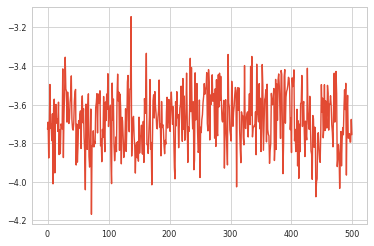

In [27]:
plt.plot(amala_samples[:,26])
plt.show()

In [ ]:
amala_samples.shape

In [ ]:
adapt_t_mala_model.acceptance_ratio(adapt_t_mala_model.proposal_sampler())

In [ ]:
adapt_t_mala_model._gamma_estimate

In [ ]:
samples2 = [tf.convert_to_tensor(a[4000:,],dtype=tf.float64) for a in np.split(amala_samples,[25],axis=-1)]

In [ ]:
samples2

In [ ]:
mover_hmc.kernel_params

In [ ]:
with tf.GradientTape() as t:
    loss = -mover_hmc.log_posterior(*mover_hmc.kernel_params)
    
gradients = t.gradient(loss, mover_hmc.kernel_params)

In [ ]:
np.linalg.norm(to_numpy(gradients))

In [ ]:
loss

In [ ]:
np.split(state,[25])

In [ ]:
tf.stack([tf.expand_dims(a,-1) for a in mover_hmc.kernel_params],axis=-1)

In [ ]:


def build_trainable_location_scale_distribution(initial_loc, initial_scale):
    
    with tf.name_scope('build_trainable_location_scale_distribution'):
        dtype = tf.float64
        initial_loc = initial_loc * tf.ones(tf.shape(initial_scale), dtype=dtype)
        
        initial_scale = initial_scale * tf.ones_like(initial_loc)

        loc = tf.Variable(initial_value=initial_loc, name='loc')
      
        
        scale=tfp.util.DeferredTensor(tf.Variable(initial_scale, name='scale'),tf.nn.softplus)

        posterior_dist = tfd.Normal(loc=loc, scale=scale)

        
        posterior_dist = tfd.Independent(posterior_dist)
        
    return posterior_dist


flat_component_dists = []


init_loc = mover_hmc.kernel_params[0]
init_scale = tf.random.uniform(shape=mover_hmc.kernel_params[0].shape, minval=-2, maxval=2, dtype=tf.dtypes.float64)

    
flat_component_dists.append(build_trainable_location_scale_distribution(init_loc,init_scale))


init_loc = mover_hmc.kernel_params[1]
init_scale = tf.random.uniform(shape=mover_hmc.kernel_params[1].shape, minval=-2, maxval=2, dtype=tf.dtypes.float64)

    
flat_component_dists.append(build_trainable_location_scale_distribution(init_loc,init_scale))

surrogate_posterior = tfd.JointDistributionSequential(flat_component_dists)



def target_log_prob_fn(*inputs):
    #params = []
    #print(inputs)
    #print('----------')
    #params.append(mover_hmc.kernel_params[0])
    #params.append(mover_hmc.kernel_params[1])
    params = [tf.squeeze(a) for a in inputs]
    loss = mover_hmc.log_posterior(*params)
    
    #print(loss)
    return loss




In [ ]:


# def build_trainable_location_scale_distribution(initial_loc, initial_scale):
    
#     with tf.name_scope('build_trainable_location_scale_distribution'):
#         dtype = tf.float64
#         initial_loc = initial_loc * tf.ones(tf.shape(initial_scale), dtype=dtype)
        
#         initial_scale = initial_scale * tf.ones_like(initial_loc)

#         loc = tf.Variable(initial_value=initial_loc, name='loc')
      
        
#         scale=tfp.util.DeferredTensor(tf.Variable(initial_scale, name='scale'),tf.nn.softplus)

#         posterior_dist = tfd.MultivariateNormalTriL(loc=loc, scale_tril=scale)

        
#         posterior_dist = tfd.Independent(posterior_dist)
        
#     return posterior_dist


# flat_component_dists = []


# init_loc = mover_hmc.kernel_params[0]
# init_scale = tf.random.uniform(shape=(mover_hmc.kernel_params[0].shape[0],mover_hmc.kernel_params[0].shape[0]), minval=-2, maxval=2, dtype=tf.dtypes.float64)

    
# flat_component_dists.append(build_trainable_location_scale_distribution(init_loc,init_scale))


# init_loc = mover_hmc.kernel_params[1]
# init_scale = tf.random.uniform(shape=(mover_hmc.kernel_params[1].shape[0],mover_hmc.kernel_params[1].shape[0]), minval=-2, maxval=2, dtype=tf.dtypes.float64)

    
# flat_component_dists.append(build_trainable_location_scale_distribution(init_loc,init_scale))

# surrogate_posterior = tfd.JointDistributionSequential(flat_component_dists)



# def target_log_prob_fn(*inputs):
#     #params = []
#     #print(inputs)
#     #print('----------')
#     #params.append(mover_hmc.kernel_params[0])
#     #params.append(mover_hmc.kernel_params[1])
#     params = [tf.squeeze(a) for a in inputs]
#     loss = mover_hmc.log_posterior(*params)
    
#     #print(loss)
#     return loss




In [ ]:
surrogate_posterior.sample()

In [ ]:
mover_hmc.kernel_params[0].shape[0]

In [ ]:


start = time.time()
losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn, surrogate_posterior,
    optimizer=tf.optimizers.Adam(
        learning_rate=0.1,
        # Decay second-moment estimates to aid optimizing scale parameters.
        beta_2=0.9),
    num_steps=5000)
end = time.time()
print(end - start)



In [ ]:
sp = surrogate_posterior.sample(10000)
sp_np = [s.numpy() for s in sp]

opt_step_size = [np.std(sp,axis=0) for sp in sp_np]

In [ ]:
#opt_step_size = [np.min(oss,0.1) for oss in opt_step_size]
#opt_step_size[0][opt_step_size[0]>0.1]=0.1
#opt_step_size[1][opt_step_size[1]>0.1]=0.1

plt.plot(opt_step_size[0])
plt.plot(opt_step_size[1])

In [ ]:
5e-2**0.5

In [ ]:
num_samples=1000
burn=1000#250
mover_hmc.num_samples = num_samples

#v=0.15
#s=1

def volatility_fn(*x):
  # Stack the input tensors together
  #return [1. / (0.5 + 0.1 * tf.math.abs(y)) for y in x]
    #return [1 for vv in opt_step_size]
    return [(vv) for vv in opt_step_size]


ss=np.float64(5)
step_size = [ss for a in opt_step_size]
inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=mover_hmc.log_posterior, step_size=bb, num_leapfrog_steps=3)#max_tree_depth=4)
#inner_kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(target_log_prob_fn=mover_hmc.log_posterior,step_size=step_size,volatility_fn=volatility_fn)
#)#, step_size=steps)#max_tree_depth=4)
kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel, num_adaptation_steps=int(burn * 0.8))
start = time.time()

samples, kernel_results = tfp.mcmc.sample_chain(num_results=num_samples, num_burnin_steps=burn, num_steps_between_results=0, current_state=mover_hmc.kernel_params, kernel=kernel)
end = time.time()

print(end - start)
mover_hmc.samples_ = samples
print(np.sum(kernel_results.inner_results.is_accepted.numpy()/num_samples))
tfp.mcmc.effective_sample_size(samples)


In [ ]:
print(end - start)
mover_hmc.samples_ = samples
print(np.sum(kernel_results.inner_results.is_accepted.numpy()/num_samples))
tfp.mcmc.effective_sample_size(samples)

In [ ]:
kernel_results.inner_results.is_accepted

In [ ]:
samples2[0]

In [29]:
#print((end - start)/60)
mover_hmc.num_samples = 500
mover_hmc.samples_ = samples2
#print(np.sum(kernel_results.is_accepted.numpy()/num_samples))
tfp.mcmc.effective_sample_size(samples2)

[<tf.Tensor: shape=(25,), dtype=float64, numpy=
 array([316.453305, 337.002635, 285.001588, 291.679221, 254.501132,
        405.269081, 375.324676, 399.965237, 353.519361, 335.373329,
        326.122086, 397.069069, 406.262447, 442.39819 , 373.826008,
        334.671285, 386.358764, 317.005463, 281.821749, 311.904708,
        357.662363, 310.47557 , 354.763571, 380.865893, 369.591135])>,
 <tf.Tensor: shape=(25,), dtype=float64, numpy=
 array([369.134647, 219.799367, 309.228356, 354.692043, 367.293529,
        351.497643, 312.192576, 358.302052, 387.062844, 340.782334,
        392.394298, 336.244955, 292.542164, 323.781593, 294.273345,
        321.174633, 420.179005, 327.080549, 383.789269, 332.064359,
        292.738499, 364.512799, 324.376737, 277.405654, 231.563872])>]

In [ ]:
print((end - start)/60)
mover_hmc.num_samples = 2000
mover_hmc.samples_ = samples2
print(np.sum(kernel_results.is_accepted.numpy()/num_samples))
tfp.mcmc.effective_sample_size(samples2)

In [ ]:
50*676/60/60

In [ ]:
plt.plot(samples2[0][:,])
plt.show()
plt.plot(samples2[0][:,0])
plt.show()

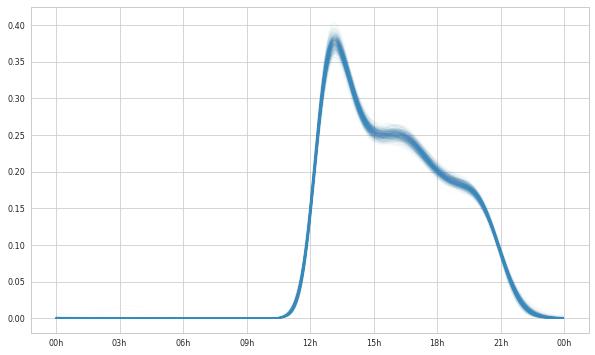

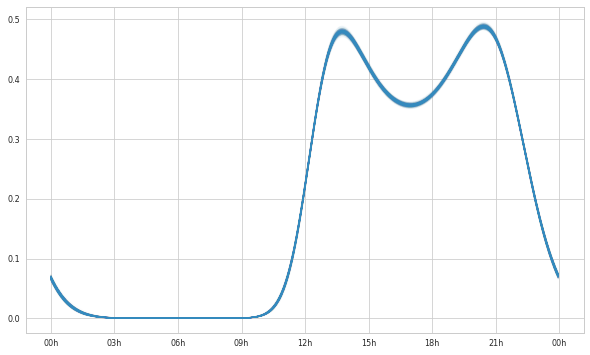

In [31]:

lengths =(mover_hmc.get_lengthscale_samples(X=Zin))
amps = (mover_hmc.get_amplitude_samples(X=Zin))
#  plot the sample for checking
plt.figure(figsize=(10,6))
Z_time=np.array([np.datetime64('2019') + np.timedelta64(int(k*60*60), 's') for k in Zin])

for i in range(0,lengths.shape[0]):
    plt.plot(Z_time[np.argsort(Z_time)],lengths[i,np.argsort(Z_time)],c='C1',alpha=0.02,linewidth=1.0)

ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)
plt.figure(figsize=(10,6))

for i in range(0,amps.shape[0]):
    plt.plot(Z_time[np.argsort(Z_time)],amps[i,np.argsort(Z_time)],c='C1', alpha=0.02,linewidth=1.0)
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)

In [ ]:
ess=tfp.mcmc.effective_sample_size(samples)
plt.plot(mover_hmc.kernel_params[0].numpy(),ess[0],'.')
plt.ylim(0,20)

In [ ]:

lengths =(mover.get_lengthscale_samples())
amps = (mover_hmc.get_amplitude_samples())

print(tfp.mcmc.effective_sample_size(lengths))
print(tfp.mcmc.effective_sample_size(amps))

In [ ]:
## compare full covar to this

In [30]:

lengths =(mover_hmc.get_lengthscale_samples())
amps = (mover_hmc.get_amplitude_samples())

print(tfp.mcmc.effective_sample_size(lengths))
print(tfp.mcmc.effective_sample_size(amps))

tf.Tensor(
[[407.631027]
 [500.      ]
 [500.      ]
 [500.      ]
 [500.      ]
 [500.      ]
 [500.      ]
 [500.      ]
 [458.805521]
 [348.45839 ]
 [314.439244]
 [313.305608]
 [381.796048]
 [355.915183]
 [370.868114]
 [310.236176]
 [393.915178]
 [324.769699]
 [297.799091]
 [358.993485]
 [354.842944]
 [356.518888]
 [331.994851]
 [309.730098]
 [317.464183]], shape=(25, 1), dtype=float64)
tf.Tensor(
[[369.461096]
 [264.351394]
 [220.998651]
 [228.934747]
 [336.775559]
 [366.176405]
 [381.396474]
 [386.46395 ]
 [385.969859]
 [376.761991]
 [314.707344]
 [277.789707]
 [255.824304]
 [368.377379]
 [368.792483]
 [343.936578]
 [286.042971]
 [335.845317]
 [385.873361]
 [324.132154]
 [374.374811]
 [395.113463]
 [320.831735]
 [339.492398]
 [341.893851]], shape=(25, 1), dtype=float64)


In [ ]:
aa = [np.std(s.numpy()[:,:],axis=0) for s in samples]
#bb = [np.std(s.numpy()[:,:],axis=0) for s in samples]

# opt_step=[]
# for a in aa:
#     opt_step.append(1e-3*a)
# opt_step
#plt.plot(aa[1])
plt.plot(bb[0])#/np.max(bb[1]))
plt.plot(aa[0])#/np.max(bb[1]))

plt.plot(opt_step_size[0]/np.max(opt_step_size[0]),'.')
#plt.ylim(0,0.1)

In [ ]:
num_samples=600
burn=0#250
mover_hmc.num_samples = num_samples

#v=0.15
#s=1

def volatility_fn(*x):
  # Stack the input tensors together
  #return [1. / (0.5 + 0.1 * tf.math.abs(y)) for y in x]
    #return [1 for vv in opt_step_size]
    return [(vv) for vv in bb]


ss=np.float64(5e-3)
step_size = [ss for a in opt_step_size]
#inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=mover_hmc.log_posterior, step_size=steps, num_leapfrog_steps=10)#max_tree_depth=4)
inner_kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(target_log_prob_fn=mover_hmc.log_posterior,step_size=step_size,volatility_fn=volatility_fn)
#)#, step_size=steps)#max_tree_depth=4)
kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel, num_adaptation_steps=int(burn * 0.8))
start = time.time()

samples, kernel_results = tfp.mcmc.sample_chain(num_results=num_samples, num_burnin_steps=burn, num_steps_between_results=100, current_state=mover_hmc.kernel_params, kernel=inner_kernel)
end = time.time()

print(end - start)
mover_hmc.samples_ = samples
print(np.sum(kernel_results.is_accepted.numpy()/num_samples))
tfp.mcmc.effective_sample_size(samples)


In [ ]:
plt.plot(samples[0][:,])
plt.show()
plt.plot(samples[0][:,3])
plt.show()

In [ ]:
gradients

In [ ]:
plt.plot(loss_history[800:])

In [ ]:
lengths = mover_hmc.get_lengthscale()
plt.plot(Z,lengths,'o',c='b')
Zin = np.linspace(0,24,num=500,endpoint=False).astype(np.float64)[:,None]

lengths = mover_hmc.get_lengthscale(X=Zin)
plt.plot(Zin,lengths)
plt.show()

amps = mover_hmc.get_amplitude()
plt.plot(Z,amps,'o',c='b')
Zin = np.linspace(0,24,num=500,endpoint=False).astype(np.float64)[:,None]
amps = mover_hmc.get_amplitude(X=Zin)
plt.plot(Zin,amps)
plt.show()


In [ ]:
opt_step = []
ss=1e-6
for var in optimizer.variables():
    #print(var)
    if '/m:' in var.name:
        opt_step.append(ss*(np.sqrt(np.abs((var.numpy()))))**-1)
        
        
plt.plot(opt_step[2][0:],'.')
#plt.show()
plt.plot(opt_step[6][0:],'.')
plt.show()
#plt.ylim(-0.5,1)
#plt.show()

for o in opt_step:
    print(o)

In [ ]:
amp_params = [kernel_params[i] for i in range(mover_hmc.a_start+2,mover_hmc.m_start)]


K_amp = mover_hmc.akernel(*[t(p) for t,p in zip(mover_hmc.atransforms, amp_params)])
L_amp = tf.linalg.cholesky(K_amp.matrix(mover_hmc.Z_,mover_hmc.Z_) + tf.eye(tf.shape(input=mover_hmc.Z_)[0], dtype=tf.float64) * mover_hmc.jitter_level)
amp_dist = tfd.MultivariateNormalTriL(scale_tril=L_amp)


ls_params = [kernel_params[i] for i in range(mover_hmc.l_start+2,mover_hmc.a_start)]

K_ls = mover_hmc.lkernel(*[t(p) for t,p in zip(mover_hmc.ltransforms, ls_params)])
L_ls = tf.linalg.cholesky(K_ls.matrix(mover_hmc.Z_,mover_hmc.Z_) + tf.eye(tf.shape(input=mover_hmc.Z_)[0], dtype=tf.float64) * mover_hmc.jitter_level)

ls_dist = tfd.MultivariateNormalTriL(scale_tril=L_ls)

In [ ]:
print(opt_amp_amp)
print(opt_ls_amp)

In [ ]:
ss=1e-2
ss_l = ss/opt_ls_amp
ss_amp = ss/opt_amp_amp

def _fn(state_parts, seed):
    
    next_state_parts = []
    for j, param in enumerate(state_parts):
        if j==1:
            next_state_parts.append(state_parts[j] + 2*ss_l*ls_dist.sample())# + 1e-1*gradients[j])
        elif j==3:
            next_state_parts.append(state_parts[j] + ss_amp*amp_dist.sample())
        else:
            next_state_parts.append(state_parts[j])

    return next_state_parts


num_samples=10#00#500
burn=0
mover_hmc.num_samples = num_samples
#skip100,nsamp1000 - gives min ess of 8 looks like with burn in would be ok

kernel = tfp.mcmc.RandomWalkMetropolis(target_log_prob_fn=mover_hmc.log_posterior, new_state_fn=_fn)

start = time.time()

samples, kernel_results = tfp.mcmc.sample_chain(num_results=num_samples, num_burnin_steps=burn, num_steps_between_results=1, current_state=mover_hmc.kernel_params, kernel=kernel)
end = time.time()
print(end - start)
mover_hmc.samples_ = samples
print(np.sum(kernel_results.is_accepted.numpy()/num_samples))

In [ ]:
10000*5619/60/60/2000
print((end - start)/60/60)
print(np.sum(kernel_results.is_accepted.numpy()/num_samples))

In [ ]:
lengths = mover_hmc.get_lengthscale_samples(X=Zin)
amps = mover_hmc.get_amplitude_samples(X=Zin)
#  plot the sample for checking
plt.figure(figsize=(10,6))
Z_time=np.array([np.datetime64('2019') + np.timedelta64(int(k*60*60), 's') for k in Zin])

for i in range(800,lengths.shape[0]):
    plt.plot(Z_time[np.argsort(Z_time)],lengths[i,np.argsort(Z_time)],c='C1',alpha=0.02,linewidth=1.0)

ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)
plt.figure(figsize=(10,6))

for i in range(800,amps.shape[0]):
    plt.plot(Z_time[np.argsort(Z_time)],amps[i,np.argsort(Z_time)],c='C1', alpha=0.02,linewidth=1.0)
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)

In [ ]:
tfp.mcmc.effective_sample_size(samples[1][800:])

In [ ]:
plt.plot(samples[1][:,:])

In [ ]:
lengths = mover_hmc.get_lengthscale_samples()


In [ ]:
num_samples=1000#000#00#00#0#500
burn=1#1000#000#5#0
mover_hmc.num_samples = num_samples
steps = []

#ss = opt_step#np.float64(1e-5)
def volatility_fn(*x):
  # Stack the input tensors together
  #return [1. / (0.5 + 0.1 * tf.math.abs(y)) for y in x]
    
    vol = []
    for i in range(len(x)):
        if i==1:
            vol.append(1e-2*tf.eye(tf.shape(x[i])[0],dtype=tf.float64))
        else:
            vol.append(1e-2)
    return vol


vol = volatility_fn(*mover_hmc.kernel_params)

In [ ]:

ss=np.float64(1e-2)
steps=[]
for i in range(len(mover_hmc.kernel_params)):
    if i==1:
        steps.append(ss*tf.ones((tf.shape(mover_hmc.kernel_params[i])[0],1),dtype=tf.float64))
    else:
        steps.append(ss)
#inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=mover_hmc.log_posterior, step_size=steps, num_leapfrog_steps=10)#max_tree_depth=4)
inner_kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(target_log_prob_fn=mover_hmc.log_posterior,step_size=steps,volatility_fn=volatility_fn)
#)#, step_size=steps)#max_tree_depth=4)
kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel, num_adaptation_steps=int(burn * 0.8))
start = time.time()

samples, kernel_results = tfp.mcmc.sample_chain(num_results=num_samples, num_burnin_steps=burn, num_steps_between_results=0, current_state=mover_hmc.kernel_params, kernel=inner_kernel)
end = time.time()
print(end - start)
mover_hmc.samples_ = samples
print(np.sum(kernel_results.is_accepted.numpy()/num_samples))
tfp.mcmc.effective_sample_size(samples)

In [ ]:
ss=np.float64(1e-2)
steps=[]
for i in range(len(mover_hmc.kernel_params)):
    if i==1:
        steps.append(ss*tf.ones((tf.shape(mover_hmc.kernel_params[i])[0],1),dtype=tf.float64))
    else:
        steps.append(ss)

tf.matmul(vol[1],steps[1])

In [ ]:
# sample from the posterior
start = time.time()
num_samples=5000
burn_in=2000
kr = mover.hmc_sample(num_samples=num_samples, skip=0, burn_in=burn_in, num_leapfrog_steps=10, init_step=opt_step)
end = time.time()
print(end - start)
print(np.sum(kr.inner_results.is_accepted.numpy()/num_samples))


In [ ]:
7000*1121/60/60/200

In [ ]:
#lengths = mover_hmc.samples_[1]

for i in range(0,lengths.shape[0]):
    plt.plot(Z,lengths[i,:],c='C1',alpha=0.02,linewidth=1.0)

In [ ]:

lengths = mover.get_lengthscale_samples(X=Zin)
amps = mover.get_amplitude_samples(X=Zin)
#  plot the sample for checking
plt.figure(figsize=(10,6))
Z_time=np.array([np.datetime64('2019') + np.timedelta64(int(k*60*60), 's') for k in Zin])

for i in range(0,lengths.shape[0]):
    plt.plot(Z_time[np.argsort(Z_time)],lengths[i,np.argsort(Z_time)],c='C1',alpha=0.02,linewidth=1.0)

ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)
plt.figure(figsize=(10,6))

for i in range(0,amps.shape[0]):
    plt.plot(Z_time[np.argsort(Z_time)],amps[i,np.argsort(Z_time)],c='C1', alpha=0.02,linewidth=1.0)
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)

In [ ]:
np.shape(mover.Z_.numpy())

In [ ]:
lengths = mover.get_lengthscale_samples()
tfp.mcmc.effective_sample_size(lengths)#[1].numpy()[39]

In [ ]:

step_size = []
for s in mover.samples_:
    
    step_size.append(np.std(s,axis=0))

In [ ]:
for s in step_size: print(s)

In [ ]:
# sample from the posterior
start = time.time()
num_samples=1000
burn_in=600
kr = mover.hmc_sample(num_samples=num_samples, skip=0, burn_in=burn_in, num_leapfrog_steps=10, init_step=step_size)
end = time.time()
print(end - start)
print(np.sum(kr.inner_results.is_accepted.numpy()/num_samples))


In [ ]:

lengths = mover.get_lengthscale_samples()
amps = mover.get_amplitude_samples()
#  plot the sample for checking
plt.figure(figsize=(10,6))
Z_time=np.array([np.datetime64('2019') + np.timedelta64(int(k*60*60), 's') for k in Z])

for i in range(0,lengths.shape[0]):
    plt.plot(Z_time[np.argsort(Z_time)],lengths[i,np.argsort(Z_time)],c='C1',alpha=0.902,linewidth=1.0)

ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)
plt.figure(figsize=(10,6))

for i in range(0,amps.shape[0]):
    plt.plot(Z_time[np.argsort(Z_time)],amps[i,np.argsort(Z_time)],c='C1', alpha=0.902,linewidth=1.0)
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)

In [ ]:
aa=tfp.mcmc.effective_sample_size(mover.samples_)#[1].numpy()[39]

plt.plot(aa[1],step_size[1],'.')
tfp.mcmc.effective_sample_size(mover.samples_)

In [ ]:
plt.plot(mover.samples_[2][:,].numpy())
plt.show()

In [ ]:
kr.new_step_size[1][0,39]

In [ ]:

opt_step = []
for var in optimizer.variables():
    if '/v:' in var.name:
        opt_step.append((np.sqrt((var.numpy())))**-1)
        
        
plt.plot(opt_step[1][0:],'.')
#plt.show()
plt.plot(opt_step[4][0:],'.')
plt.show()
#plt.ylim(-0.5,1)
#plt.show()

for o in opt_step:
    print(o)

In [ ]:
plt.plot(loss_history[200:])
plt.show()
loss.numpy()

In [ ]:
1600*942/40/60/60


In [ ]:
np.exp(mover.kernel_params[mover.l_start].numpy())

In [ ]:
plt.plot(Z,(mover.kernel_params[2]).numpy(),'-o')
#plt.ylim(0,0.5)
plt.show()
plt.plot(Z,(mover.kernel_params[6]).numpy(),'-o')
plt.show()
#6

In [ ]:


opt_step = []
for var in optimizer.variables():
    if '/v:' in var.name:
        opt_step.append((np.sqrt((var.numpy()))+1e-16)**-1)
        
        
plt.plot(opt_step[3][0:25],'.')
#plt.plot(opt_step[6][0:25],'.')
#plt.ylim(-0.5,1)
#plt.show()

for o in opt_step:
    print(o.dtype)

In [ ]:
optimizer.variables()

In [ ]:
for i in range(len(opt_step)):
    o=opt_step[i]
    if len(o.shape):
        o[o>1]=1
    opt_step[i]=o#opt_step[i]*0+1e-2
    print(opt_step[i])

In [ ]:
for j, param in enumerate(mover.kernel_params):
    print(j,(param.numpy()),param.shape)

In [ ]:
tf.math.exp(-1.5)

In [ ]:

# with open('opt_step.npy', 'wb') as fp:
#     pickle.dump(opt_step, fp)

In [ ]:

    
# with open ('opt_step.npy', 'rb') as fp:
#     opt_step = pickle.load(fp)
#mover.log_posterior(*mover.kernel_params)


In [ ]:
opt_ls_mean

In [ ]:
mover.log_posterior(*mover.kernel_params)


In [ ]:
mover_hmc.kernel_params.log_posterior(*mover_hmc.kernel_params)

In [ ]:
# lengths = mover_hmc.get_lengthscale()
# plt.plot(Z,lengths,'o',c='b')
# Zin = np.linspace(0,24,num=500,endpoint=False).astype(np.float64)[:,None]

# lengths = mover_hmc.get_lengthscale(X=Zin)
# plt.plot(Zin,lengths)
# plt.show()

amps = mover_hmc.get_amplitude()
plt.plot(Z,amps,'o',c='b')
Zin = np.linspace(0,24,num=500,endpoint=False).astype(np.float64)[:,None]
amps = mover_hmc.get_amplitude(X=Zin)
plt.plot(Zin,amps)
plt.show()



In [ ]:
num_samples=2000#0#500
burn=0#5#0
mover_hmc.num_samples = num_samples
steps = []

ss = np.float64(1e-5)
def volatility_fn(*x):
  # Stack the input tensors together
  #return [1. / (0.5 + 0.1 * tf.math.abs(y)) for y in x]
  return [1. for y in x]

for j, param in enumerate(mover_hmc.kernel_params):
    if j==1:
        steps.append(ss)
    elif j==3:
        steps.append(ss)
    else:
        steps.append(ss)
#inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=mover_hmc.log_posterior, step_size=steps, num_leapfrog_steps=10)#max_tree_depth=4)
inner_kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(target_log_prob_fn=mover_hmc.log_posterior,step_size=ss,volatility_fn=volatility_fn)
#)#, step_size=steps)#max_tree_depth=4)
kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel, num_adaptation_steps=int(burn * 0.8))
start = time.time()

samples, kernel_results = tfp.mcmc.sample_chain(num_results=num_samples, num_burnin_steps=burn, num_steps_between_results=0, current_state=mover_hmc.kernel_params, kernel=inner_kernel)
end = time.time()
print(end - start)
mover_hmc.samples_ = samples
print(np.sum(kernel_results.is_accepted.numpy()/num_samples))
tfp.mcmc.effective_sample_size(samples)

In [ ]:
tfp.mcmc.effective_sample_size(samples)[1].numpy()[39]

In [ ]:
lengths = mover_hmc.get_lengthscale_samples()
amps = mover_hmc.get_amplitude_samples()

aa=tfp.mcmc.effective_sample_size(lengths).numpy()
plt.plot(Z,aa,'.')
aa=tfp.mcmc.effective_sample_size(amps).numpy()
plt.plot(Z,aa,'.')

plt.show()
plt.plot(Z,lengths[0,...],'.')

plt.plot(Z,amps[0,...],'.')

plt.show()
plt.plot(Z,mover_hmc.samples_[1][0,...],'.')
plt.show()

aa=tfp.mcmc.effective_sample_size(lengths).numpy()
plt.plot(Z,aa,'.')
#plt.plot(Z,amps[0,...],'.')

In [ ]:
def cauchy_new_state_fn(scale, dtype):
  cauchy = tfd.Normal(loc=np.float64(0), scale=np.float64(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    part_seeds = tfp.random.split_seed(
        seed, n=len(state_parts), salt='rwmcauchy')
    for sp, ps in zip(state_parts, part_seeds):
      next_state_parts.append(sp + cauchy.sample(
        sample_shape=sp.shape, seed=ps))
    return next_state_parts
  return _fn

In [ ]:
tfp.mcmc.effective_sample_size(samples)

In [ ]:
print(end - start)


In [ ]:
learning_rate = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10,
    decay_rate=0.99,
    staircase=True)


optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)#,beta_2=0.99)
train_steps = 500#00#00
pbar = tqdm(range(train_steps))
loss_history = np.zeros((train_steps))
for i in pbar:
    with tf.GradientTape() as t:
        loss = -mover_hmc.log_posterior(*mover_hmc.kernel_params)
    loss_history[i] = loss.numpy()#mover_hmc.kernel_params[1].numpy()[39]
    pbar.set_description("Loss %f" % loss_history[i])

    gradients = t.gradient(loss, mover_hmc.kernel_params)
    optimizer.apply_gradients(zip(gradients, mover_hmc.kernel_params))
    #print(gradients)
#n=3.5


In [ ]:
plt.plot(loss_history[50:])
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

@tf.function
def test_():
    def target_fn(*input):
        return -mover_hmc.log_posterior(*input)
    fn_val, grads = tfp.math.value_and_gradient(target_fn, mover_hmc.kernel_params)

# # We can either pass the `sample_shape` of the `state` or not, which impacts
# # computational speed of `diag_jacobian`
    _, diag_jacobian_shape_passed = tfp.math.diag_jacobian(
       xs=mover_hmc.kernel_params, ys=grads, sample_shape=tf.shape(fn_val))
# _, diag_jacobian_shape_none = diag_jacobian(
#   xs=state, ys=grads)

# diag_jacobian_shape_passed_ = sess.run(diag_jacobian_shape_passed)
# diag_jacobian_shape_none_ = sess.run(diag_jacobian_shape_none)

# print('hessian computed through `diag_jacobian`, sample_shape passed: ',
#   np.concatenate(diag_jacobian_shape_passed_, -1))
# print('hessian computed through `diag_jacobian`, sample_shape skipped',
#   np.concatenate(diag_jacobian_shape_none_, -1))
    return diag_jacobian_shape_passed

In [ ]:
test_()

In [ ]:
optimizer.variables()


In [ ]:
with tf.GradientTape(persistent=True) as t2:
    with tf.GradientTape(persistent=True) as t:
        loss = -mover_hmc.log_posterior(*mover_hmc.kernel_params)
    #aa = tf.hessians(loss,mover_hmc.kernel_params)
    gradients = t.gradient(loss, mover_hmc.kernel_params)

#gradients2 = t2.gradient(gradients,mover_hmc.kernel_params)
gradients
    #gradients = t.gradient(loss, mover_hmc.kernel_params)

In [ ]:
loss

In [ ]:

def calc_hessian_diag(f, x):
    """
    Calculates the diagonal entries of the Hessian of the function f
    (which maps rank-1 tensors to scalars) at coordinates x (rank-1
    tensors).
    
    Let k be the number of points in x, and n be the dimensionality of
    each point. For each point k, the function returns

      (d^2f/dx_1^2, d^2f/dx_2^2, ..., d^2f/dx_n^2) .

    Inputs:
      f (function): Takes a shape-(k,n) tensor and outputs a
          shape-(k,) tensor.
      x (tf.Tensor): The points at which to evaluate the Laplacian
          of f. Shape = (k,n).
    
    Outputs:
      A tensor containing the diagonal entries of the Hessian of f at
      points x. Shape = (k,n).
    """
    # Use the unstacking and re-stacking trick, which comes
    # from https://github.com/xuzhiqin1990/laplacian/
    with tf.GradientTape(persistent=True) as g1:
        # Turn x into a list of n tensors of shape (k,)
        x_unstacked = tf.unstack(x, axis=0)
        g1.watch(x_unstacked)

        with tf.GradientTape() as g2:
            # Re-stack x before passing it into f
            x_stacked = tf.stack(x_unstacked, axis=0) # shape = (k,n)
            g2.watch(x_stacked)
            f_x = f(x_stacked) # shape = (k,)
        
        # Calculate gradient of f with respect to x
        df_dx = g2.gradient(f_x, x_stacked) # shape = (k,n)
        # Turn df/dx into a list of n tensors of shape (k,)
        df_dx_unstacked = tf.unstack(df_dx, axis=0)

    # Calculate 2nd derivatives
    d2f_dx2 = []
    for df_dxi,xi in zip(df_dx_unstacked, x_unstacked):
        # Take 2nd derivative of each dimension separately:
        #   d/dx_i (df/dx_i)
        d2f_dx2.append(g1.gradient(df_dxi, xi))
    
    # Stack 2nd derivates
    d2f_dx2_stacked = tf.stack(d2f_dx2, axis=1) # shape = (k,n)
    
    return d2f_dx2_stacked

f = lambda q : tf.math.log(tf.math.reduce_sum(q**2, axis=1))
x = tf.random.uniform((5,3))

d2f_dx2 = calc_hessian_diag(f, x)
print(d2f_dx2)

In [ ]:
def target_fn(inputvar):
    
    params = [inputvar]
    for p in mover_hmc.kernel_params[1:]:
        params.append(p)
    return -mover_hmc.log_posterior(*params)
#fn_val, grads = tfp.math.value_and_gradient(target_fn, mover_hmc.kernel_params)

calc_hessian_diag(target_fn,tf.expand_dims(mover_hmc.kernel_params[0],-1))

In [ ]:
@tf.function
def train():
    learning_rate = tf.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-1,
        decay_steps=10,
        decay_rate=0.99,
        staircase=True)


    optimizer = tfp.optimizer.StochasticGradientLangevinDynamics(learning_rate=1e-1)
    train_steps = 200
    pbar = tqdm(range(train_steps))
    loss_history = np.zeros((train_steps))
    for i in pbar:
        with tf.GradientTape() as t:
            loss = -mover_hmc.log_posterior(*mover_hmc.kernel_params)
        #loss_history[i] = loss.numpy()
        #pbar.set_description("Loss %f" % loss_history[i])

        gradients = t.gradient(loss, mover_hmc.kernel_params)
        optimizer.apply_gradients(zip(gradients, mover_hmc.kernel_params))
#n=3.5

In [ ]:
train()

In [ ]:
plt.plot(loss_history[8000:])
plt.show()
loss.numpy()

In [ ]:
lengths = mover_hmc.get_lengthscale()
plt.plot(Z,lengths*np.ones_like(Z),'o',c='b')
Zin = np.linspace(0,24,num=500,endpoint=False).astype(np.float64)[:,None]

lengths = mover_hmc.get_lengthscale(X=Zin)
plt.plot(Zin,lengths*np.ones_like(Zin))
plt.show()

amps = mover_hmc.get_amplitude()
plt.plot(Z,amps,'o',c='b')
Zin = np.linspace(0,24,num=500,endpoint=False).astype(np.float64)[:,None]
amps = mover_hmc.get_amplitude(X=Zin)
plt.plot(Zin,amps)
plt.show()



In [ ]:
plt.plot(s2,'-o')

In [ ]:
plt.plot(s1)

In [ ]:
# # sample from the posterior
kr = mover.hmc_sample(num_samples=1, skip=0, burn_in=0, num_leapfrog_steps=1, init_step=1e-8)
# lengths = mover.get_lengthscale_samples()
# amps = mover.get_amplitude_samples()
# #  plot the sample for checking
# plt.figure(figsize=(10,6))
# Z_time=np.array([np.datetime64('2019') + np.timedelta64(int(k*60*60), 's') for k in Z])

# for i in range(0,lengths.shape[0]):
#     plt.plot(Z_time[np.argsort(Z_time)],lengths[i,np.argsort(Z_time)],c='C1',alpha=0.902,linewidth=1.0)

# ax = plt.gca()
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(myFmt)
# plt.figure(figsize=(10,6))

# for i in range(0,amps.shape[0]):
#     plt.plot(Z_time[np.argsort(Z_time)],amps[i,np.argsort(Z_time)],c='C1', alpha=0.902,linewidth=1.0)
# ax = plt.gca()
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(myFmt)

In [ ]:

ss = np.float64(1e-2)
steps = []
for j, param in enumerate(mover.kernel_params):
    steps.append(ss)

# steps = []
# for j, param in enumerate(mover.kernel_params):
#     if j==2:
#         steps.append(ss)
#     elif j==6:
#         steps.append(ss)
#     else:
#         steps.append(0)
start = time.time()

num_samples=200#500
burn=10
start = time.time()
mover.num_samples = num_samples
#kr = mover.nuts_sample(num_samples=num_samples, skip=0, burn_in=burn, init_step=steps)

end = time.time()
print(i,end - start)


In [ ]:
mover_hmc.kernel_params

In [ ]:
num_samples=10#500
burn=10

ss = np.float64(1e-3)


steps = ss
# for j, param in enumerate(mover_hmc.kernel_params):
#     if j==2:
#         steps.append(ss)
#     else:
#         steps.append(0)
inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=mover_hmc.log_posterior, step_size=steps, num_leapfrog_steps=20)
kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel, num_adaptation_steps=int(burn * 0.8))
start = time.time()

samples, kernel_results = tfp.mcmc.sample_chain(num_results=num_samples, num_burnin_steps=burn, num_steps_between_results=0, current_state=mover_hmc.kernel_params, kernel=inner_kernel)
end = time.time()
print(end - start)
mover_hmc.samples_ = samples
print(np.sum(kernel_results.is_accepted.numpy()/num_samples))


In [ ]:
tfp.mcmc.effective_sample_size(samples)

In [ ]:
tfp.mcmc.effective_sample_size(samples)

In [ ]:
359*10/60

In [ ]:
tfp.mcmc.effective_sample_size(samples)

In [ ]:
plt.plot(samples[1][:,:].numpy())
plt.show()
aa=tfp.mcmc.effective_sample_size(samples)[1].numpy()

plt.plot(mover_hmc.kernel_params[1].numpy(),aa,'.')

In [ ]:
tfp.mcmc.effective_sample_size(samples)

In [ ]:


def _fn(state_parts, seed):
    next_state_parts = []
    for j, param in enumerate(state_parts):
        if j==1:
            norm = tfd.Normal(loc=np.float64(0), scale=np.float64(0.005))

            next_state_parts.append(state_parts[j] + norm.sample(sample_shape=state_parts[j].shape))
        else:
            next_state_parts.append(state_parts[j])

    return next_state_parts


num_samples=2000#00#500
burn=200
mover_hmc.num_samples = num_samples


kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(target_log_prob_fn=mover_hmc.log_posterior, step_size=0.000025)

start = time.time()

samples, kernel_results = tfp.mcmc.sample_chain(num_results=num_samples, num_burnin_steps=burn, num_steps_between_results=10, current_state=mover_hmc.kernel_params, kernel=kernel)
end = time.time()
print(end - start)
mover_hmc.samples_ = samples
print(np.sum(kernel_results.is_accepted.numpy()/num_samples))

In [ ]:
tfp.mcmc.effective_sample_size(samples)

In [ ]:
plt.plot(samples[1][:,:].numpy())
plt.show()
aa=tfp.mcmc.effective_sample_size(samples)[1].numpy()

plt.plot(mover_hmc.kernel_params[1].numpy(),aa,'.')

In [ ]:
stepsizes=np.std(samples[1].numpy(),axis=0)
plt.plot(aa,stepsizes,'.')

In [ ]:
num_samples=2000#500
burn=2000

ss = np.float64(1e-3)


steps = []
for j, param in enumerate(mover_hmc.kernel_params):
    if j==1:
        steps.append(ss*stepsizes)
    else:
        steps.append(ss*step_ls)
inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=mover_hmc.log_posterior, step_size=steps, num_leapfrog_steps=20)
kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel, num_adaptation_steps=int(burn * 0.8))
start = time.time()

samples, kernel_results = tfp.mcmc.sample_chain(num_results=num_samples, num_burnin_steps=burn, num_steps_between_results=0, current_state=mover_hmc.kernel_params, kernel=inner_kernel)
end = time.time()
print(end - start)
mover_hmc.samples_ = samples
print(np.sum(kernel_results.is_accepted.numpy()/num_samples))

In [ ]:
step_ls=np.std(samples[0].numpy(),axis=0)

In [ ]:
tfp.mcmc.effective_sample_size(samples)

In [ ]:
3574*10/60/60

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import numpy as np

tf.enable_v2_behavior()

dtype = np.float32
true_mean = dtype([0, 0, 0])
true_cov = dtype([[1, 0.25, 0.25], [0.25, 1, 0.25], [0.25, 0.25, 1]])
num_results = 500
num_chains = 500

# Target distribution is defined through the Cholesky decomposition
chol = tf.linalg.cholesky(true_cov)
target = tfd.MultivariateNormalTriL(loc=true_mean, scale_tril=chol)

# Here we define the volatility function to be non-constant
def volatility_fn(x):
  # Stack the input tensors together
  return 1. / (0.5 + 0.1 * tf.math.abs(x))

# Initial state of the chain
init_state = np.ones([num_chains, 3], dtype=dtype)

# Run MALA with normal proposal for `num_results` iterations for
# `num_chains` independent chains:
states = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state,
    kernel=tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
        target_log_prob_fn=target.log_prob,
        step_size=.1,
        volatility_fn=volatility_fn),
    num_burnin_steps=200,
    num_steps_between_results=1,
    trace_fn=None)

sample_mean = tf.reduce_mean(states, axis=[0, 1])
x = (states - sample_mean)[..., tf.newaxis]
sample_cov = tf.reduce_mean(
    tf.matmul(x, tf.transpose(x, [0, 1, 3, 2])), [0, 1])

print('sample mean', sample_mean.numpy())
print('sample covariance matrix', sample_cov.numpy())


In [ ]:
1 108.34
2 295
3 638
4 1322

In [ ]:
kernel_results.new_step_size

In [ ]:
# steps = []
# for j, param in enumerate(mover.kernel_params):
#     print(j,mover.kernel_params[j].shape)
#     if j==2:
#         steps.append(10*s1)
#     elif j==6:
#         steps.append(10*s2)
#     else:
#         steps.append(0)

In [ ]:
start = time.time()
# 200/200 took 6.31 - run for 1000/1000 = 31.551hrs
num_samples=250#00
burn_in=100#500  ## 100/250
num_runs=1#4
rescale = 24

for i in range(num_runs):
    ss = np.float64(1e-3)
    steps = []
    for j, param in enumerate(mover.kernel_params):
        steps.append(ss)
    steps=opt_step
    kr = mover.nuts_sample(num_samples=num_samples, skip=0, burn_in=burn_in, max_tree_depth=5, init_step=steps)
   
    # save the results
    final_hmc_np = [j.numpy() for j in  mover.samples_]
    with open('data/hmc_samples_p_' + str(i) + '.npy', 'wb') as fp:
        pickle.dump(final_hmc_np, fp)
        
    lengths = mover.get_lengthscale_samples()
    amps = mover.get_amplitude_samples()
    np.save('data/len_sheep_p_' + str(i) + '.npy',lengths)
    np.save('data/amp_sheep_p_' + str(i) + '.npy',amps)
    

    Zin = np.linspace(0,24,num=200,endpoint=False).astype(np.float64)[:,None]

    # sample from the posterior)
    lengths = mover.get_lengthscale_samples(X=Zin)
    amps = mover.get_amplitude_samples(X=Zin)

    np.save('data/full_len_sheep_p_' + str(i) + '.npy',lengths)
    np.save('data/full_amp_sheep_p_' + str(i) + '.npy',amps)
    np.save('data/Z_pred_p_' + str(i) + '.npy',Zin)

    
    end = time.time()
    print(i,end - start)

In [ ]:
kr.new_step_size

In [ ]:

start = time.time()
# 200/200 took 6.31 - run for 1000/1000 = 31.551hrs
num_samples=1500
burn_in=500
num_runs=1
rescale = 24

for i in range(num_runs):
    steps = []
    
    ss = np.float64(1e-1)
    
    for j, param in enumerate(mover_hmc.kernel_params):
        if j==1:
            steps.append(s1)
        elif j==3:
            steps.append(s2)
        else:
            steps.append(0)
    kr = mover_hmc.hmc_sample(num_samples=num_samples, skip=0, burn_in=burn_in, num_leapfrog_steps=5, init_step=steps)
   
    # save the results
    final_hmc_np = [j.numpy() for j in  mover_hmc.samples_]
    with open('data/hmc_samples_p_' + str(i) + '.npy', 'wb') as fp:
        pickle.dump(final_hmc_np, fp)
        
    lengths = mover_hmc.get_lengthscale_samples()
    amps = mover_hmc.get_amplitude_samples()
    np.save('data/len_sheep_p_' + str(i) + '.npy',lengths)
    np.save('data/amp_sheep_p_' + str(i) + '.npy',amps)
    

    Zin = np.linspace(0,24,num=200,endpoint=False).astype(np.float64)[:,None]

    # sample from the posterior)
    lengths = mover_hmc.get_lengthscale_samples(X=Zin)
    amps = mover_hmc.get_amplitude_samples(X=Zin)

    np.save('data/full_len_sheep_p_' + str(i) + '.npy',lengths)
    np.save('data/full_amp_sheep_p_' + str(i) + '.npy',amps)
    np.save('data/Z_pred_p_' + str(i) + '.npy',Zin)

    
    end = time.time()
    print(i,end - start)

In [ ]:
print('time: ',10*(end - start)/60/60)

print(np.sum(kernel_results.inner_results.is_accepted.numpy()/num_samples))


In [ ]:
kr.new_step_size


In [ ]:
25.4872/5*6

In [ ]:
for mp in mover.kernel_params:
    print(mp)
    
    

In [ ]:
rescale = 24
Zin = np.linspace(0,24,num=500,endpoint=False).astype(np.float64)[:,None]

lengths = mover_hmc.get_lengthscale_samples(X=Zin)
amps = mover_hmc.get_amplitude_samples(X=Zin)

In [ ]:

Zin = np.linspace(0,24,num=500,endpoint=False).astype(np.float64)[:,None]

# sample from the posterior)
lengths = mover.get_lengthscale_samples(X=Zin)
amps = mover.get_amplitude_samples(X=Zin)


In [ ]:
#  plot the sample for checking
plt.figure(figsize=(10,6))


# Z_time=np.array([np.datetime64('2019') + np.timedelta64(int(k*60*60), 's') for k in Zin])

# for i in range(0,lengths.shape[0]):
#     plt.plot(Z_time[np.argsort(Z_time)],lengths[i,np.argsort(Z_time)],c='C1',alpha=0.902,linewidth=1.0)

# ax = plt.gca()
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(myFmt)
plt.figure(figsize=(10,6))

for i in range(0,amps.shape[0]):
    plt.plot(Z_time[np.argsort(Z_time)],amps[i,np.argsort(Z_time)],c='C1', alpha=0.02,linewidth=1.0)
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)